# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-5)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # Aufruf LR scheduler für reduce on plateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/25, Loss: 0.0968
Epoch 1/200, Iteration 2/25, Loss: 1.5827
Epoch 1/200, Iteration 3/25, Loss: 3.3954
Epoch 1/200, Iteration 4/25, Loss: 2.4420
Epoch 1/200, Iteration 5/25, Loss: 0.7839
Epoch 1/200, Iteration 6/25, Loss: 0.4864
Epoch 1/200, Iteration 7/25, Loss: 0.9160
Epoch 1/200, Iteration 8/25, Loss: 0.8079
Epoch 1/200, Iteration 9/25, Loss: 0.5091
Epoch 1/200, Iteration 10/25, Loss: 0.1298
Epoch 1/200, Iteration 11/25, Loss: 0.3578
Epoch 1/200, Iteration 12/25, Loss: 0.5806
Epoch 1/200, Iteration 13/25, Loss: 0.4806
Epoch 1/200, Iteration 14/25, Loss: 0.3086
Epoch 1/200, Iteration 15/25, Loss: 0.2181
Epoch 1/200, Iteration 16/25, Loss: 0.3078
Epoch 1/200, Iteration 17/25, Loss: 0.2044
Epoch 1/200, Iteration 18/25, Loss: 0.2136
Epoch 1/200, Iteration 19/25, Loss: 0.1783
Epoch 1/200, Iteration 20/25, Loss: 0.1417
Epoch 1/200, Iteration 21/25, Loss: 0.1744
Epoch 1/200, Iteration 22/25, Loss: 0.0828
Epoch 1/200, Iteration 23/25, Loss: 0.1568
Epoch 1/200, Iterati

Train Error: 
 Accuracy: 54.87%, Avg loss: 0.039405, MRE: 2.308749 

Test Error: 
 Accuracy: 53.5%, Avg loss: 0.041077, MRE: 3.959250 

Epoch 8/200, Iteration 1/25, Loss: 0.0420
Epoch 8/200, Iteration 2/25, Loss: 0.0396
Epoch 8/200, Iteration 3/25, Loss: 0.0330
Epoch 8/200, Iteration 4/25, Loss: 0.0309
Epoch 8/200, Iteration 5/25, Loss: 0.0279
Epoch 8/200, Iteration 6/25, Loss: 0.0326
Epoch 8/200, Iteration 7/25, Loss: 0.0252
Epoch 8/200, Iteration 8/25, Loss: 0.0403
Epoch 8/200, Iteration 9/25, Loss: 0.0330
Epoch 8/200, Iteration 10/25, Loss: 0.0500
Epoch 8/200, Iteration 11/25, Loss: 0.0324
Epoch 8/200, Iteration 12/25, Loss: 0.0467
Epoch 8/200, Iteration 13/25, Loss: 0.0368
Epoch 8/200, Iteration 14/25, Loss: 0.0361
Epoch 8/200, Iteration 15/25, Loss: 0.0365
Epoch 8/200, Iteration 16/25, Loss: 0.0455
Epoch 8/200, Iteration 17/25, Loss: 0.0541
Epoch 8/200, Iteration 18/25, Loss: 0.0400
Epoch 8/200, Iteration 19/25, Loss: 0.0624
Epoch 8/200, Iteration 20/25, Loss: 0.0394
Epoch 8/200, 

Epoch 14/200, Iteration 19/25, Loss: 0.0488
Epoch 14/200, Iteration 20/25, Loss: 0.0800
Epoch 14/200, Iteration 21/25, Loss: 0.0852
Epoch 14/200, Iteration 22/25, Loss: 0.0440
Epoch 14/200, Iteration 23/25, Loss: 0.0874
Epoch 14/200, Iteration 24/25, Loss: 0.0553
Epoch 14/200, Iteration 25/25, Loss: 0.0466
Train Error: 
 Accuracy: 69.0%, Avg loss: 0.040757, MRE: 1.881117 

Test Error: 
 Accuracy: 69.5%, Avg loss: 0.041531, MRE: 6.016363 

Epoch 15/200, Iteration 1/25, Loss: 0.0463
Epoch 15/200, Iteration 2/25, Loss: 0.1048
Epoch 15/200, Iteration 3/25, Loss: 0.0416
Epoch 15/200, Iteration 4/25, Loss: 0.1563
Epoch 15/200, Iteration 5/25, Loss: 0.0504
Epoch 15/200, Iteration 6/25, Loss: 0.2056
Epoch 15/200, Iteration 7/25, Loss: 0.1755
Epoch 15/200, Iteration 8/25, Loss: 0.0556
Epoch 15/200, Iteration 9/25, Loss: 0.1645
Epoch 15/200, Iteration 10/25, Loss: 0.1621
Epoch 15/200, Iteration 11/25, Loss: 0.0464
Epoch 15/200, Iteration 12/25, Loss: 0.1841
Epoch 15/200, Iteration 13/25, Loss: 0

Epoch 21/200, Iteration 12/25, Loss: 0.0326
Epoch 21/200, Iteration 13/25, Loss: 0.0248
Epoch 21/200, Iteration 14/25, Loss: 0.0285
Epoch 21/200, Iteration 15/25, Loss: 0.0631
Epoch 21/200, Iteration 16/25, Loss: 0.0586
Epoch 21/200, Iteration 17/25, Loss: 0.0408
Epoch 21/200, Iteration 18/25, Loss: 0.0183
Epoch 21/200, Iteration 19/25, Loss: 0.0291
Epoch 21/200, Iteration 20/25, Loss: 0.0324
Epoch 21/200, Iteration 21/25, Loss: 0.0525
Epoch 21/200, Iteration 22/25, Loss: 0.0379
Epoch 21/200, Iteration 23/25, Loss: 0.0384
Epoch 21/200, Iteration 24/25, Loss: 0.0246
Epoch 21/200, Iteration 25/25, Loss: 0.0433
Train Error: 
 Accuracy: 62.0%, Avg loss: 0.031271, MRE: 1.762829 

Test Error: 
 Accuracy: 61.0%, Avg loss: 0.031164, MRE: 4.462272 

Epoch 22/200, Iteration 1/25, Loss: 0.0373
Epoch 22/200, Iteration 2/25, Loss: 0.0471
Epoch 22/200, Iteration 3/25, Loss: 0.0406
Epoch 22/200, Iteration 4/25, Loss: 0.0277
Epoch 22/200, Iteration 5/25, Loss: 0.0338
Epoch 22/200, Iteration 6/25, Loss

Epoch 28/200, Iteration 7/25, Loss: 0.0298
Epoch 28/200, Iteration 8/25, Loss: 0.0318
Epoch 28/200, Iteration 9/25, Loss: 0.0310
Epoch 28/200, Iteration 10/25, Loss: 0.0186
Epoch 28/200, Iteration 11/25, Loss: 0.0321
Epoch 28/200, Iteration 12/25, Loss: 0.0280
Epoch 28/200, Iteration 13/25, Loss: 0.0137
Epoch 28/200, Iteration 14/25, Loss: 0.0181
Epoch 28/200, Iteration 15/25, Loss: 0.0264
Epoch 28/200, Iteration 16/25, Loss: 0.0330
Epoch 28/200, Iteration 17/25, Loss: 0.0194
Epoch 28/200, Iteration 18/25, Loss: 0.0232
Epoch 28/200, Iteration 19/25, Loss: 0.0304
Epoch 28/200, Iteration 20/25, Loss: 0.0310
Epoch 28/200, Iteration 21/25, Loss: 0.0305
Epoch 28/200, Iteration 22/25, Loss: 0.0260
Epoch 28/200, Iteration 23/25, Loss: 0.0385
Epoch 28/200, Iteration 24/25, Loss: 0.0431
Epoch 28/200, Iteration 25/25, Loss: 0.0289
Train Error: 
 Accuracy: 65.12%, Avg loss: 0.017026, MRE: 0.973606 

Test Error: 
 Accuracy: 63.0%, Avg loss: 0.019126, MRE: 2.837998 

Epoch 29/200, Iteration 1/25, L

Train Error: 
 Accuracy: 64.25%, Avg loss: 0.021434, MRE: 1.350087 

Test Error: 
 Accuracy: 62.0%, Avg loss: 0.023345, MRE: 5.162460 

Epoch 35/200, Iteration 1/25, Loss: 0.0223
Epoch 35/200, Iteration 2/25, Loss: 0.0280
Epoch 35/200, Iteration 3/25, Loss: 0.0209
Epoch 35/200, Iteration 4/25, Loss: 0.0271
Epoch 35/200, Iteration 5/25, Loss: 0.0242
Epoch 35/200, Iteration 6/25, Loss: 0.0235
Epoch 35/200, Iteration 7/25, Loss: 0.0223
Epoch 35/200, Iteration 8/25, Loss: 0.0444
Epoch 35/200, Iteration 9/25, Loss: 0.0312
Epoch 35/200, Iteration 10/25, Loss: 0.0295
Epoch 35/200, Iteration 11/25, Loss: 0.0166
Epoch 35/200, Iteration 12/25, Loss: 0.0252
Epoch 35/200, Iteration 13/25, Loss: 0.0402
Epoch 35/200, Iteration 14/25, Loss: 0.0422
Epoch 35/200, Iteration 15/25, Loss: 0.0538
Epoch 35/200, Iteration 16/25, Loss: 0.0299
Epoch 35/200, Iteration 17/25, Loss: 0.0203
Epoch 35/200, Iteration 18/25, Loss: 0.0222
Epoch 35/200, Iteration 19/25, Loss: 0.0287
Epoch 35/200, Iteration 20/25, Loss: 

Epoch 41/200, Iteration 19/25, Loss: 0.0133
Epoch 41/200, Iteration 20/25, Loss: 0.0308
Epoch 41/200, Iteration 21/25, Loss: 0.0130
Epoch 41/200, Iteration 22/25, Loss: 0.0145
Epoch 41/200, Iteration 23/25, Loss: 0.0167
Epoch 41/200, Iteration 24/25, Loss: 0.0167
Epoch 41/200, Iteration 25/25, Loss: 0.0169
Train Error: 
 Accuracy: 81.0%, Avg loss: 0.011355, MRE: 0.597522 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.014394, MRE: 2.163741 

Epoch 42/200, Iteration 1/25, Loss: 0.0128
Epoch 42/200, Iteration 2/25, Loss: 0.0161
Epoch 42/200, Iteration 3/25, Loss: 0.0145
Epoch 42/200, Iteration 4/25, Loss: 0.0218
Epoch 42/200, Iteration 5/25, Loss: 0.0138
Epoch 42/200, Iteration 6/25, Loss: 0.0142
Epoch 42/200, Iteration 7/25, Loss: 0.0332
Epoch 42/200, Iteration 8/25, Loss: 0.0227
Epoch 42/200, Iteration 9/25, Loss: 0.0180
Epoch 42/200, Iteration 10/25, Loss: 0.0193
Epoch 42/200, Iteration 11/25, Loss: 0.0151
Epoch 42/200, Iteration 12/25, Loss: 0.0221
Epoch 42/200, Iteration 13/25, Loss: 0

Epoch 49/200, Iteration 2/25, Loss: 0.0180
Epoch 49/200, Iteration 3/25, Loss: 0.0196
Epoch 49/200, Iteration 4/25, Loss: 0.0149
Epoch 49/200, Iteration 5/25, Loss: 0.0221
Epoch 49/200, Iteration 6/25, Loss: 0.0209
Epoch 49/200, Iteration 7/25, Loss: 0.0179
Epoch 49/200, Iteration 8/25, Loss: 0.0108
Epoch 49/200, Iteration 9/25, Loss: 0.0210
Epoch 49/200, Iteration 10/25, Loss: 0.0208
Epoch 49/200, Iteration 11/25, Loss: 0.0173
Epoch 49/200, Iteration 12/25, Loss: 0.0170
Epoch 49/200, Iteration 13/25, Loss: 0.0191
Epoch 49/200, Iteration 14/25, Loss: 0.0310
Epoch 49/200, Iteration 15/25, Loss: 0.0127
Epoch 49/200, Iteration 16/25, Loss: 0.0129
Epoch 49/200, Iteration 17/25, Loss: 0.0254
Epoch 49/200, Iteration 18/25, Loss: 0.0131
Epoch 49/200, Iteration 19/25, Loss: 0.0150
Epoch 49/200, Iteration 20/25, Loss: 0.0172
Epoch 49/200, Iteration 21/25, Loss: 0.0184
Epoch 49/200, Iteration 22/25, Loss: 0.0191
Epoch 49/200, Iteration 23/25, Loss: 0.0154
Epoch 49/200, Iteration 24/25, Loss: 0.0

Epoch 56/200, Iteration 10/25, Loss: 0.0145
Epoch 56/200, Iteration 11/25, Loss: 0.0215
Epoch 56/200, Iteration 12/25, Loss: 0.0123
Epoch 56/200, Iteration 13/25, Loss: 0.0186
Epoch 56/200, Iteration 14/25, Loss: 0.0451
Epoch 56/200, Iteration 15/25, Loss: 0.0136
Epoch 56/200, Iteration 16/25, Loss: 0.0264
Epoch 56/200, Iteration 17/25, Loss: 0.0126
Epoch 56/200, Iteration 18/25, Loss: 0.0154
Epoch 56/200, Iteration 19/25, Loss: 0.0161
Epoch 56/200, Iteration 20/25, Loss: 0.0083
Epoch 56/200, Iteration 21/25, Loss: 0.0357
Epoch 56/200, Iteration 22/25, Loss: 0.0290
Epoch 56/200, Iteration 23/25, Loss: 0.0153
Epoch 56/200, Iteration 24/25, Loss: 0.0145
Epoch 56/200, Iteration 25/25, Loss: 0.0132
Train Error: 
 Accuracy: 84.75%, Avg loss: 0.010627, MRE: 0.544192 

Test Error: 
 Accuracy: 82.0%, Avg loss: 0.013451, MRE: 2.008566 

Epoch 57/200, Iteration 1/25, Loss: 0.0171
Epoch 57/200, Iteration 2/25, Loss: 0.0170
Epoch 57/200, Iteration 3/25, Loss: 0.0258
Epoch 57/200, Iteration 4/25, L

Train Error: 
 Accuracy: 75.5%, Avg loss: 0.010468, MRE: 0.602474 

Test Error: 
 Accuracy: 70.0%, Avg loss: 0.013055, MRE: 1.739042 

Epoch 64/200, Iteration 1/25, Loss: 0.0177
Epoch 64/200, Iteration 2/25, Loss: 0.0171
Epoch 64/200, Iteration 3/25, Loss: 0.0193
Epoch 64/200, Iteration 4/25, Loss: 0.0180
Epoch 64/200, Iteration 5/25, Loss: 0.0199
Epoch 64/200, Iteration 6/25, Loss: 0.0177
Epoch 64/200, Iteration 7/25, Loss: 0.0337
Epoch 64/200, Iteration 8/25, Loss: 0.0327
Epoch 64/200, Iteration 9/25, Loss: 0.0126
Epoch 64/200, Iteration 10/25, Loss: 0.0102
Epoch 64/200, Iteration 11/25, Loss: 0.0132
Epoch 64/200, Iteration 12/25, Loss: 0.0155
Epoch 64/200, Iteration 13/25, Loss: 0.0096
Epoch 64/200, Iteration 14/25, Loss: 0.0244
Epoch 64/200, Iteration 15/25, Loss: 0.0183
Epoch 64/200, Iteration 16/25, Loss: 0.0172
Epoch 64/200, Iteration 17/25, Loss: 0.0123
Epoch 64/200, Iteration 18/25, Loss: 0.0113
Epoch 64/200, Iteration 19/25, Loss: 0.0141
Epoch 64/200, Iteration 20/25, Loss: 0

Epoch 71/200, Iteration 11/25, Loss: 0.0106
Epoch 71/200, Iteration 12/25, Loss: 0.0124
Epoch 71/200, Iteration 13/25, Loss: 0.0107
Epoch 71/200, Iteration 14/25, Loss: 0.0346
Epoch 71/200, Iteration 15/25, Loss: 0.0154
Epoch 71/200, Iteration 16/25, Loss: 0.0080
Epoch 71/200, Iteration 17/25, Loss: 0.0126
Epoch 71/200, Iteration 18/25, Loss: 0.0181
Epoch 71/200, Iteration 19/25, Loss: 0.0151
Epoch 71/200, Iteration 20/25, Loss: 0.0166
Epoch 71/200, Iteration 21/25, Loss: 0.0326
Epoch 71/200, Iteration 22/25, Loss: 0.0213
Epoch 71/200, Iteration 23/25, Loss: 0.0214
Epoch 71/200, Iteration 24/25, Loss: 0.0169
Epoch 71/200, Iteration 25/25, Loss: 0.0136
Train Error: 
 Accuracy: 84.88%, Avg loss: 0.010361, MRE: 0.546897 

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.013569, MRE: 1.832237 

Epoch 72/200, Iteration 1/25, Loss: 0.0232
Epoch 72/200, Iteration 2/25, Loss: 0.0124
Epoch 72/200, Iteration 3/25, Loss: 0.0196
Epoch 72/200, Iteration 4/25, Loss: 0.0153
Epoch 72/200, Iteration 5/25, Lo

Epoch 78/200, Iteration 16/25, Loss: 0.0234
Epoch 78/200, Iteration 17/25, Loss: 0.0116
Epoch 78/200, Iteration 18/25, Loss: 0.0152
Epoch 78/200, Iteration 19/25, Loss: 0.0253
Epoch 78/200, Iteration 20/25, Loss: 0.0178
Epoch 78/200, Iteration 21/25, Loss: 0.0145
Epoch 78/200, Iteration 22/25, Loss: 0.0165
Epoch 78/200, Iteration 23/25, Loss: 0.0120
Epoch 78/200, Iteration 24/25, Loss: 0.0183
Epoch 78/200, Iteration 25/25, Loss: 0.0166
Train Error: 
 Accuracy: 80.75%, Avg loss: 0.010277, MRE: 0.565446 

Test Error: 
 Accuracy: 77.0%, Avg loss: 0.013140, MRE: 1.953857 

Epoch 79/200, Iteration 1/25, Loss: 0.0135
Epoch 79/200, Iteration 2/25, Loss: 0.0226
Epoch 79/200, Iteration 3/25, Loss: 0.0206
Epoch 79/200, Iteration 4/25, Loss: 0.0129
Epoch 79/200, Iteration 5/25, Loss: 0.0175
Epoch 79/200, Iteration 6/25, Loss: 0.0136
Epoch 79/200, Iteration 7/25, Loss: 0.0139
Epoch 79/200, Iteration 8/25, Loss: 0.0142
Epoch 79/200, Iteration 9/25, Loss: 0.0188
Epoch 79/200, Iteration 10/25, Loss: 

Epoch 85/200, Iteration 13/25, Loss: 0.0196
Epoch 85/200, Iteration 14/25, Loss: 0.0163
Epoch 85/200, Iteration 15/25, Loss: 0.0294
Epoch 85/200, Iteration 16/25, Loss: 0.0200
Epoch 85/200, Iteration 17/25, Loss: 0.0148
Epoch 85/200, Iteration 18/25, Loss: 0.0252
Epoch 85/200, Iteration 19/25, Loss: 0.0206
Epoch 85/200, Iteration 20/25, Loss: 0.0144
Epoch 85/200, Iteration 21/25, Loss: 0.0138
Epoch 85/200, Iteration 22/25, Loss: 0.0253
Epoch 85/200, Iteration 23/25, Loss: 0.0124
Epoch 85/200, Iteration 24/25, Loss: 0.0276
Epoch 85/200, Iteration 25/25, Loss: 0.0096
Train Error: 
 Accuracy: 84.12%, Avg loss: 0.010230, MRE: 0.513008 

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.013222, MRE: 1.837798 

Epoch 86/200, Iteration 1/25, Loss: 0.0170
Epoch 86/200, Iteration 2/25, Loss: 0.0256
Epoch 86/200, Iteration 3/25, Loss: 0.0411
Epoch 86/200, Iteration 4/25, Loss: 0.0149
Epoch 86/200, Iteration 5/25, Loss: 0.0352
Epoch 86/200, Iteration 6/25, Loss: 0.0303
Epoch 86/200, Iteration 7/25, Loss

Train Error: 
 Accuracy: 77.62%, Avg loss: 0.010175, MRE: 0.570512 

Test Error: 
 Accuracy: 69.0%, Avg loss: 0.012743, MRE: 1.677073 

Epoch 93/200, Iteration 1/25, Loss: 0.0301
Epoch 93/200, Iteration 2/25, Loss: 0.0174
Epoch 93/200, Iteration 3/25, Loss: 0.0139
Epoch 93/200, Iteration 4/25, Loss: 0.0406
Epoch 93/200, Iteration 5/25, Loss: 0.0153
Epoch 93/200, Iteration 6/25, Loss: 0.0159
Epoch 93/200, Iteration 7/25, Loss: 0.0118
Epoch 93/200, Iteration 8/25, Loss: 0.0144
Epoch 93/200, Iteration 9/25, Loss: 0.0106
Epoch 93/200, Iteration 10/25, Loss: 0.0194
Epoch 93/200, Iteration 11/25, Loss: 0.0160
Epoch 93/200, Iteration 12/25, Loss: 0.0117
Epoch 93/200, Iteration 13/25, Loss: 0.0153
Epoch 93/200, Iteration 14/25, Loss: 0.0150
Epoch 93/200, Iteration 15/25, Loss: 0.0143
Epoch 93/200, Iteration 16/25, Loss: 0.0207
Epoch 93/200, Iteration 17/25, Loss: 0.0187
Epoch 93/200, Iteration 18/25, Loss: 0.0160
Epoch 93/200, Iteration 19/25, Loss: 0.0064
Epoch 93/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 79.88%, Avg loss: 0.009850, MRE: 0.532759 

Test Error: 
 Accuracy: 72.0%, Avg loss: 0.012656, MRE: 1.759646 

Epoch 100/200, Iteration 1/25, Loss: 0.0137
Epoch 100/200, Iteration 2/25, Loss: 0.0150
Epoch 100/200, Iteration 3/25, Loss: 0.0130
Epoch 100/200, Iteration 4/25, Loss: 0.0153
Epoch 100/200, Iteration 5/25, Loss: 0.0136
Epoch 100/200, Iteration 6/25, Loss: 0.0105
Epoch 100/200, Iteration 7/25, Loss: 0.0145
Epoch 100/200, Iteration 8/25, Loss: 0.0169
Epoch 100/200, Iteration 9/25, Loss: 0.0212
Epoch 100/200, Iteration 10/25, Loss: 0.0192
Epoch 100/200, Iteration 11/25, Loss: 0.0141
Epoch 100/200, Iteration 12/25, Loss: 0.0147
Epoch 100/200, Iteration 13/25, Loss: 0.0257
Epoch 100/200, Iteration 14/25, Loss: 0.0151
Epoch 100/200, Iteration 15/25, Loss: 0.0232
Epoch 100/200, Iteration 16/25, Loss: 0.0122
Epoch 100/200, Iteration 17/25, Loss: 0.0187
Epoch 100/200, Iteration 18/25, Loss: 0.0169
Epoch 100/200, Iteration 19/25, Loss: 0.0126
Epoch 100/200, Ite

Epoch 106/200, Iteration 20/25, Loss: 0.0148
Epoch 106/200, Iteration 21/25, Loss: 0.0141
Epoch 106/200, Iteration 22/25, Loss: 0.0456
Epoch 106/200, Iteration 23/25, Loss: 0.0212
Epoch 106/200, Iteration 24/25, Loss: 0.0139
Epoch 106/200, Iteration 25/25, Loss: 0.0109
Train Error: 
 Accuracy: 83.62%, Avg loss: 0.009837, MRE: 0.502150 

Test Error: 
 Accuracy: 78.5%, Avg loss: 0.012554, MRE: 1.753014 

Epoch 107/200, Iteration 1/25, Loss: 0.0144
Epoch 107/200, Iteration 2/25, Loss: 0.0234
Epoch 107/200, Iteration 3/25, Loss: 0.0112
Epoch 107/200, Iteration 4/25, Loss: 0.0233
Epoch 107/200, Iteration 5/25, Loss: 0.0130
Epoch 107/200, Iteration 6/25, Loss: 0.0112
Epoch 107/200, Iteration 7/25, Loss: 0.0129
Epoch 107/200, Iteration 8/25, Loss: 0.0232
Epoch 107/200, Iteration 9/25, Loss: 0.0156
Epoch 107/200, Iteration 10/25, Loss: 0.0202
Epoch 107/200, Iteration 11/25, Loss: 0.0454
Epoch 107/200, Iteration 12/25, Loss: 0.0099
Epoch 107/200, Iteration 13/25, Loss: 0.0406
Epoch 107/200, Ite

Epoch 113/200, Iteration 17/25, Loss: 0.0132
Epoch 113/200, Iteration 18/25, Loss: 0.0155
Epoch 113/200, Iteration 19/25, Loss: 0.0099
Epoch 113/200, Iteration 20/25, Loss: 0.0288
Epoch 113/200, Iteration 21/25, Loss: 0.0179
Epoch 113/200, Iteration 22/25, Loss: 0.0112
Epoch 113/200, Iteration 23/25, Loss: 0.0129
Epoch 113/200, Iteration 24/25, Loss: 0.0225
Epoch 113/200, Iteration 25/25, Loss: 0.0255
Train Error: 
 Accuracy: 76.0%, Avg loss: 0.010089, MRE: 0.574718 

Test Error: 
 Accuracy: 70.0%, Avg loss: 0.012527, MRE: 1.702241 

Epoch 114/200, Iteration 1/25, Loss: 0.0112
Epoch 114/200, Iteration 2/25, Loss: 0.0125
Epoch 114/200, Iteration 3/25, Loss: 0.0141
Epoch 114/200, Iteration 4/25, Loss: 0.0212
Epoch 114/200, Iteration 5/25, Loss: 0.0213
Epoch 114/200, Iteration 6/25, Loss: 0.0126
Epoch 114/200, Iteration 7/25, Loss: 0.0155
Epoch 114/200, Iteration 8/25, Loss: 0.0236
Epoch 114/200, Iteration 9/25, Loss: 0.0169
Epoch 114/200, Iteration 10/25, Loss: 0.0168
Epoch 114/200, Iter

Epoch 120/200, Iteration 21/25, Loss: 0.0106
Epoch 120/200, Iteration 22/25, Loss: 0.0167
Epoch 120/200, Iteration 23/25, Loss: 0.0166
Epoch 120/200, Iteration 24/25, Loss: 0.0228
Epoch 120/200, Iteration 25/25, Loss: 0.0227
Train Error: 
 Accuracy: 68.25%, Avg loss: 0.010758, MRE: 0.625974 

Test Error: 
 Accuracy: 65.5%, Avg loss: 0.012930, MRE: 1.687659 

Epoch 121/200, Iteration 1/25, Loss: 0.0151
Epoch 121/200, Iteration 2/25, Loss: 0.0195
Epoch 121/200, Iteration 3/25, Loss: 0.0099
Epoch 121/200, Iteration 4/25, Loss: 0.0108
Epoch 121/200, Iteration 5/25, Loss: 0.0114
Epoch 121/200, Iteration 6/25, Loss: 0.0263
Epoch 121/200, Iteration 7/25, Loss: 0.0221
Epoch 121/200, Iteration 8/25, Loss: 0.0087
Epoch 121/200, Iteration 9/25, Loss: 0.0106
Epoch 121/200, Iteration 10/25, Loss: 0.0095
Epoch 121/200, Iteration 11/25, Loss: 0.0150
Epoch 121/200, Iteration 12/25, Loss: 0.0146
Epoch 121/200, Iteration 13/25, Loss: 0.0109
Epoch 121/200, Iteration 14/25, Loss: 0.0180
Epoch 121/200, Ite

Epoch 127/200, Iteration 16/25, Loss: 0.0166
Epoch 127/200, Iteration 17/25, Loss: 0.0125
Epoch 127/200, Iteration 18/25, Loss: 0.0252
Epoch 127/200, Iteration 19/25, Loss: 0.0112
Epoch 127/200, Iteration 20/25, Loss: 0.0121
Epoch 127/200, Iteration 21/25, Loss: 0.0157
Epoch 127/200, Iteration 22/25, Loss: 0.0178
Epoch 127/200, Iteration 23/25, Loss: 0.0167
Epoch 127/200, Iteration 24/25, Loss: 0.0338
Epoch 127/200, Iteration 25/25, Loss: 0.0173
Train Error: 
 Accuracy: 82.0%, Avg loss: 0.009703, MRE: 0.506983 

Test Error: 
 Accuracy: 77.5%, Avg loss: 0.012204, MRE: 1.941052 

Epoch 128/200, Iteration 1/25, Loss: 0.0197
Epoch 128/200, Iteration 2/25, Loss: 0.0147
Epoch 128/200, Iteration 3/25, Loss: 0.0128
Epoch 128/200, Iteration 4/25, Loss: 0.0094
Epoch 128/200, Iteration 5/25, Loss: 0.0188
Epoch 128/200, Iteration 6/25, Loss: 0.0322
Epoch 128/200, Iteration 7/25, Loss: 0.0183
Epoch 128/200, Iteration 8/25, Loss: 0.0231
Epoch 128/200, Iteration 9/25, Loss: 0.0152
Epoch 128/200, Iter

Epoch 134/200, Iteration 8/25, Loss: 0.0112
Epoch 134/200, Iteration 9/25, Loss: 0.0229
Epoch 134/200, Iteration 10/25, Loss: 0.0149
Epoch 134/200, Iteration 11/25, Loss: 0.0119
Epoch 134/200, Iteration 12/25, Loss: 0.0134
Epoch 134/200, Iteration 13/25, Loss: 0.0159
Epoch 134/200, Iteration 14/25, Loss: 0.0163
Epoch 134/200, Iteration 15/25, Loss: 0.0128
Epoch 134/200, Iteration 16/25, Loss: 0.0139
Epoch 134/200, Iteration 17/25, Loss: 0.0099
Epoch 134/200, Iteration 18/25, Loss: 0.0215
Epoch 134/200, Iteration 19/25, Loss: 0.0130
Epoch 134/200, Iteration 20/25, Loss: 0.0125
Epoch 134/200, Iteration 21/25, Loss: 0.0128
Epoch 134/200, Iteration 22/25, Loss: 0.0486
Epoch 134/200, Iteration 23/25, Loss: 0.0129
Epoch 134/200, Iteration 24/25, Loss: 0.0110
Epoch 134/200, Iteration 25/25, Loss: 0.0137
Train Error: 
 Accuracy: 71.62%, Avg loss: 0.010402, MRE: 0.547525 

Test Error: 
 Accuracy: 66.0%, Avg loss: 0.012708, MRE: 1.708225 

Epoch 135/200, Iteration 1/25, Loss: 0.0107
Epoch 135/20

Epoch 141/200, Iteration 3/25, Loss: 0.0196
Epoch 141/200, Iteration 4/25, Loss: 0.0227
Epoch 141/200, Iteration 5/25, Loss: 0.0195
Epoch 141/200, Iteration 6/25, Loss: 0.0230
Epoch 141/200, Iteration 7/25, Loss: 0.0172
Epoch 141/200, Iteration 8/25, Loss: 0.0138
Epoch 141/200, Iteration 9/25, Loss: 0.0123
Epoch 141/200, Iteration 10/25, Loss: 0.0125
Epoch 141/200, Iteration 11/25, Loss: 0.0118
Epoch 141/200, Iteration 12/25, Loss: 0.0345
Epoch 141/200, Iteration 13/25, Loss: 0.0163
Epoch 141/200, Iteration 14/25, Loss: 0.0114
Epoch 141/200, Iteration 15/25, Loss: 0.0083
Epoch 141/200, Iteration 16/25, Loss: 0.0189
Epoch 141/200, Iteration 17/25, Loss: 0.0119
Epoch 141/200, Iteration 18/25, Loss: 0.0189
Epoch 141/200, Iteration 19/25, Loss: 0.0214
Epoch 141/200, Iteration 20/25, Loss: 0.0274
Epoch 141/200, Iteration 21/25, Loss: 0.0174
Epoch 141/200, Iteration 22/25, Loss: 0.0173
Epoch 141/200, Iteration 23/25, Loss: 0.0150
Epoch 141/200, Iteration 24/25, Loss: 0.0454
Epoch 141/200, It

Epoch 148/200, Iteration 2/25, Loss: 0.0127
Epoch 148/200, Iteration 3/25, Loss: 0.0123
Epoch 148/200, Iteration 4/25, Loss: 0.0150
Epoch 148/200, Iteration 5/25, Loss: 0.0154
Epoch 148/200, Iteration 6/25, Loss: 0.0268
Epoch 148/200, Iteration 7/25, Loss: 0.0181
Epoch 148/200, Iteration 8/25, Loss: 0.0118
Epoch 148/200, Iteration 9/25, Loss: 0.0118
Epoch 148/200, Iteration 10/25, Loss: 0.0197
Epoch 148/200, Iteration 11/25, Loss: 0.0155
Epoch 148/200, Iteration 12/25, Loss: 0.0144
Epoch 148/200, Iteration 13/25, Loss: 0.0176
Epoch 148/200, Iteration 14/25, Loss: 0.0149
Epoch 148/200, Iteration 15/25, Loss: 0.0216
Epoch 148/200, Iteration 16/25, Loss: 0.0143
Epoch 148/200, Iteration 17/25, Loss: 0.0131
Epoch 148/200, Iteration 18/25, Loss: 0.0223
Epoch 148/200, Iteration 19/25, Loss: 0.0169
Epoch 148/200, Iteration 20/25, Loss: 0.0128
Epoch 148/200, Iteration 21/25, Loss: 0.0126
Epoch 148/200, Iteration 22/25, Loss: 0.0187
Epoch 148/200, Iteration 23/25, Loss: 0.0114
Epoch 148/200, Ite

Epoch 155/200, Iteration 6/25, Loss: 0.0103
Epoch 155/200, Iteration 7/25, Loss: 0.0193
Epoch 155/200, Iteration 8/25, Loss: 0.0114
Epoch 155/200, Iteration 9/25, Loss: 0.0273
Epoch 155/200, Iteration 10/25, Loss: 0.0263
Epoch 155/200, Iteration 11/25, Loss: 0.0119
Epoch 155/200, Iteration 12/25, Loss: 0.0093
Epoch 155/200, Iteration 13/25, Loss: 0.0227
Epoch 155/200, Iteration 14/25, Loss: 0.0089
Epoch 155/200, Iteration 15/25, Loss: 0.0096
Epoch 155/200, Iteration 16/25, Loss: 0.0354
Epoch 155/200, Iteration 17/25, Loss: 0.0137
Epoch 155/200, Iteration 18/25, Loss: 0.0170
Epoch 155/200, Iteration 19/25, Loss: 0.0154
Epoch 155/200, Iteration 20/25, Loss: 0.0218
Epoch 155/200, Iteration 21/25, Loss: 0.0122
Epoch 155/200, Iteration 22/25, Loss: 0.0102
Epoch 155/200, Iteration 23/25, Loss: 0.0107
Epoch 155/200, Iteration 24/25, Loss: 0.0110
Epoch 155/200, Iteration 25/25, Loss: 0.0167
Train Error: 
 Accuracy: 81.75%, Avg loss: 0.009408, MRE: 0.509709 

Test Error: 
 Accuracy: 76.0%, Avg 

Epoch 162/200, Iteration 12/25, Loss: 0.0168
Epoch 162/200, Iteration 13/25, Loss: 0.0198
Epoch 162/200, Iteration 14/25, Loss: 0.0139
Epoch 162/200, Iteration 15/25, Loss: 0.0086
Epoch 162/200, Iteration 16/25, Loss: 0.0376
Epoch 162/200, Iteration 17/25, Loss: 0.0180
Epoch 162/200, Iteration 18/25, Loss: 0.0104
Epoch 162/200, Iteration 19/25, Loss: 0.0126
Epoch 162/200, Iteration 20/25, Loss: 0.0167
Epoch 162/200, Iteration 21/25, Loss: 0.0339
Epoch 162/200, Iteration 22/25, Loss: 0.0122
Epoch 162/200, Iteration 23/25, Loss: 0.0159
Epoch 162/200, Iteration 24/25, Loss: 0.0196
Epoch 162/200, Iteration 25/25, Loss: 0.0159
Train Error: 
 Accuracy: 82.75%, Avg loss: 0.009386, MRE: 0.502138 

Test Error: 
 Accuracy: 76.5%, Avg loss: 0.012228, MRE: 1.690131 

Epoch 163/200, Iteration 1/25, Loss: 0.0201
Epoch 163/200, Iteration 2/25, Loss: 0.0128
Epoch 163/200, Iteration 3/25, Loss: 0.0326
Epoch 163/200, Iteration 4/25, Loss: 0.0117
Epoch 163/200, Iteration 5/25, Loss: 0.0141
Epoch 163/200,

Epoch 169/200, Iteration 2/25, Loss: 0.0272
Epoch 169/200, Iteration 3/25, Loss: 0.0117
Epoch 169/200, Iteration 4/25, Loss: 0.0155
Epoch 169/200, Iteration 5/25, Loss: 0.0245
Epoch 169/200, Iteration 6/25, Loss: 0.0099
Epoch 169/200, Iteration 7/25, Loss: 0.0151
Epoch 169/200, Iteration 8/25, Loss: 0.0150
Epoch 169/200, Iteration 9/25, Loss: 0.0171
Epoch 169/200, Iteration 10/25, Loss: 0.0126
Epoch 169/200, Iteration 11/25, Loss: 0.0191
Epoch 169/200, Iteration 12/25, Loss: 0.0108
Epoch 169/200, Iteration 13/25, Loss: 0.0166
Epoch 169/200, Iteration 14/25, Loss: 0.0133
Epoch 169/200, Iteration 15/25, Loss: 0.0130
Epoch 169/200, Iteration 16/25, Loss: 0.0104
Epoch 169/200, Iteration 17/25, Loss: 0.0100
Epoch 169/200, Iteration 18/25, Loss: 0.0233
Epoch 169/200, Iteration 19/25, Loss: 0.0097
Epoch 169/200, Iteration 20/25, Loss: 0.0104
Epoch 169/200, Iteration 21/25, Loss: 0.0135
Epoch 169/200, Iteration 22/25, Loss: 0.0266
Epoch 169/200, Iteration 23/25, Loss: 0.0116
Epoch 169/200, Ite

Epoch 176/200, Iteration 3/25, Loss: 0.0088
Epoch 176/200, Iteration 4/25, Loss: 0.0102
Epoch 176/200, Iteration 5/25, Loss: 0.0148
Epoch 176/200, Iteration 6/25, Loss: 0.0147
Epoch 176/200, Iteration 7/25, Loss: 0.0178
Epoch 176/200, Iteration 8/25, Loss: 0.0122
Epoch 176/200, Iteration 9/25, Loss: 0.0132
Epoch 176/200, Iteration 10/25, Loss: 0.0195
Epoch 176/200, Iteration 11/25, Loss: 0.0148
Epoch 176/200, Iteration 12/25, Loss: 0.0088
Epoch 176/200, Iteration 13/25, Loss: 0.0281
Epoch 176/200, Iteration 14/25, Loss: 0.0181
Epoch 176/200, Iteration 15/25, Loss: 0.0362
Epoch 176/200, Iteration 16/25, Loss: 0.0152
Epoch 176/200, Iteration 17/25, Loss: 0.0189
Epoch 176/200, Iteration 18/25, Loss: 0.0129
Epoch 176/200, Iteration 19/25, Loss: 0.0098
Epoch 176/200, Iteration 20/25, Loss: 0.0130
Epoch 176/200, Iteration 21/25, Loss: 0.0357
Epoch 176/200, Iteration 22/25, Loss: 0.0118
Epoch 176/200, Iteration 23/25, Loss: 0.0113
Epoch 176/200, Iteration 24/25, Loss: 0.0154
Epoch 176/200, It

Train Error: 
 Accuracy: 86.75%, Avg loss: 0.009500, MRE: 0.476198 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.012271, MRE: 1.851196 

Epoch 183/200, Iteration 1/25, Loss: 0.0139
Epoch 183/200, Iteration 2/25, Loss: 0.0120
Epoch 183/200, Iteration 3/25, Loss: 0.0160
Epoch 183/200, Iteration 4/25, Loss: 0.0149
Epoch 183/200, Iteration 5/25, Loss: 0.0090
Epoch 183/200, Iteration 6/25, Loss: 0.0126
Epoch 183/200, Iteration 7/25, Loss: 0.0201
Epoch 183/200, Iteration 8/25, Loss: 0.0260
Epoch 183/200, Iteration 9/25, Loss: 0.0100
Epoch 183/200, Iteration 10/25, Loss: 0.0177
Epoch 183/200, Iteration 11/25, Loss: 0.0115
Epoch 183/200, Iteration 12/25, Loss: 0.0113
Epoch 183/200, Iteration 13/25, Loss: 0.0176
Epoch 183/200, Iteration 14/25, Loss: 0.0086
Epoch 183/200, Iteration 15/25, Loss: 0.0156
Epoch 183/200, Iteration 16/25, Loss: 0.0143
Epoch 183/200, Iteration 17/25, Loss: 0.0176
Epoch 183/200, Iteration 18/25, Loss: 0.0124
Epoch 183/200, Iteration 19/25, Loss: 0.0202
Epoch 183/200, Ite

Epoch 190/200, Iteration 5/25, Loss: 0.0305
Epoch 190/200, Iteration 6/25, Loss: 0.0150
Epoch 190/200, Iteration 7/25, Loss: 0.0118
Epoch 190/200, Iteration 8/25, Loss: 0.0156
Epoch 190/200, Iteration 9/25, Loss: 0.0139
Epoch 190/200, Iteration 10/25, Loss: 0.0182
Epoch 190/200, Iteration 11/25, Loss: 0.0116
Epoch 190/200, Iteration 12/25, Loss: 0.0088
Epoch 190/200, Iteration 13/25, Loss: 0.0107
Epoch 190/200, Iteration 14/25, Loss: 0.0145
Epoch 190/200, Iteration 15/25, Loss: 0.0142
Epoch 190/200, Iteration 16/25, Loss: 0.0105
Epoch 190/200, Iteration 17/25, Loss: 0.0124
Epoch 190/200, Iteration 18/25, Loss: 0.0158
Epoch 190/200, Iteration 19/25, Loss: 0.0179
Epoch 190/200, Iteration 20/25, Loss: 0.0223
Epoch 190/200, Iteration 21/25, Loss: 0.0115
Epoch 190/200, Iteration 22/25, Loss: 0.0276
Epoch 190/200, Iteration 23/25, Loss: 0.0114
Epoch 190/200, Iteration 24/25, Loss: 0.0132
Epoch 190/200, Iteration 25/25, Loss: 0.0146
Train Error: 
 Accuracy: 84.25%, Avg loss: 0.009340, MRE: 0.

Epoch 197/200, Iteration 24/25, Loss: 0.0105
Epoch 197/200, Iteration 25/25, Loss: 0.0133
Train Error: 
 Accuracy: 85.88%, Avg loss: 0.009455, MRE: 0.483467 

Test Error: 
 Accuracy: 80.5%, Avg loss: 0.012241, MRE: 1.836347 

Epoch 198/200, Iteration 1/25, Loss: 0.0121
Epoch 198/200, Iteration 2/25, Loss: 0.0098
Epoch 198/200, Iteration 3/25, Loss: 0.0283
Epoch 198/200, Iteration 4/25, Loss: 0.0127
Epoch 198/200, Iteration 5/25, Loss: 0.0150
Epoch 198/200, Iteration 6/25, Loss: 0.0616
Epoch 198/200, Iteration 7/25, Loss: 0.0161
Epoch 198/200, Iteration 8/25, Loss: 0.0102
Epoch 198/200, Iteration 9/25, Loss: 0.0230
Epoch 198/200, Iteration 10/25, Loss: 0.0117
Epoch 198/200, Iteration 11/25, Loss: 0.0146
Epoch 198/200, Iteration 12/25, Loss: 0.0126
Epoch 198/200, Iteration 13/25, Loss: 0.0115
Epoch 198/200, Iteration 14/25, Loss: 0.0151
Epoch 198/200, Iteration 15/25, Loss: 0.0185
Epoch 198/200, Iteration 16/25, Loss: 0.0310
Epoch 198/200, Iteration 17/25, Loss: 0.0164
Epoch 198/200, Ite

#### Plots loss vs Epoch

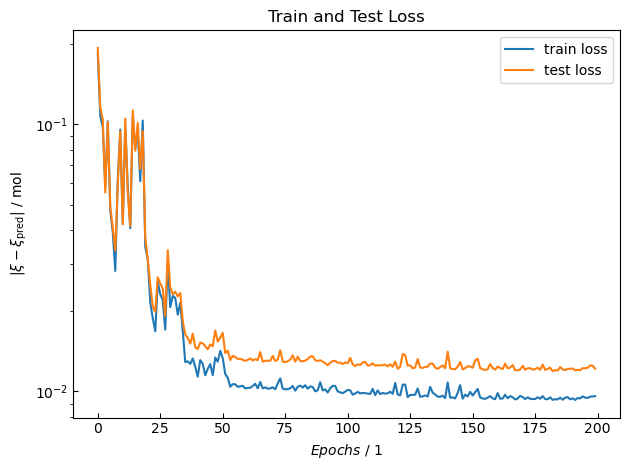

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

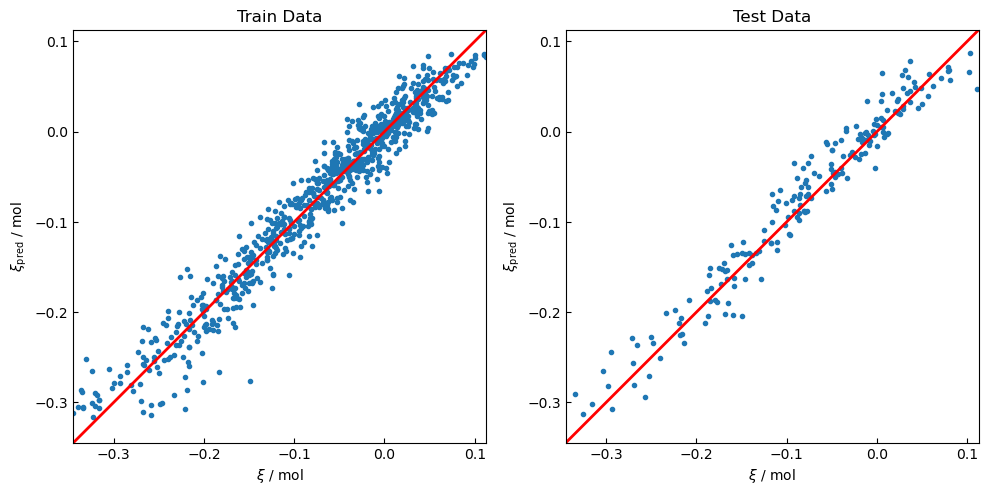

In [10]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

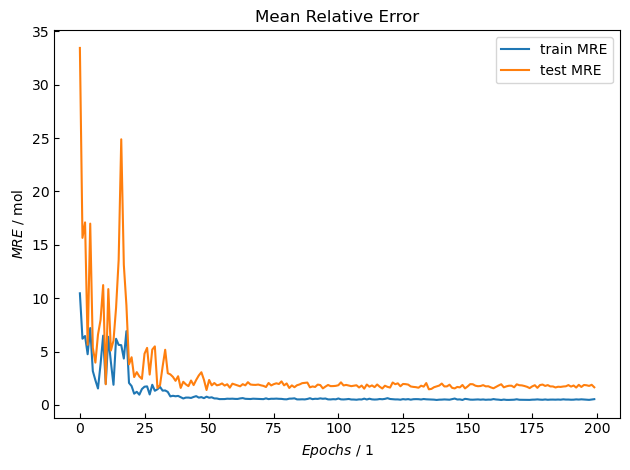

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

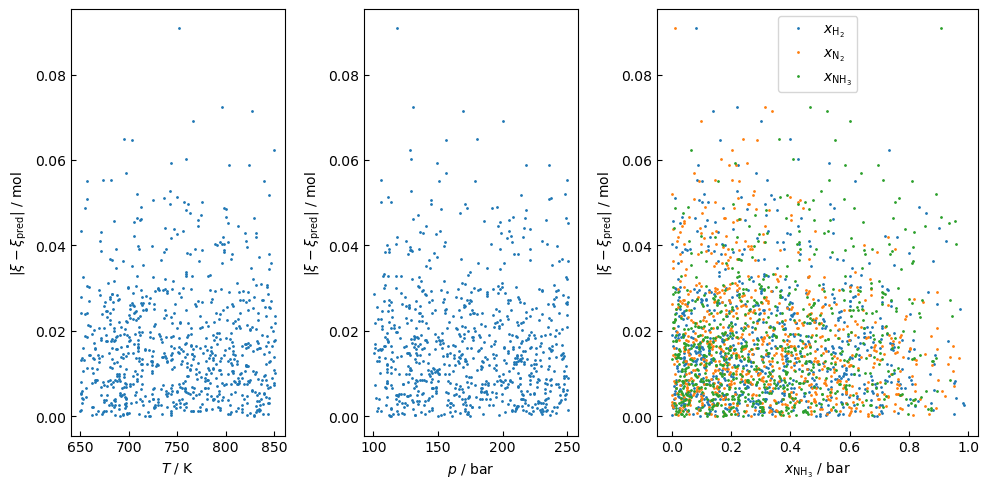

In [12]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

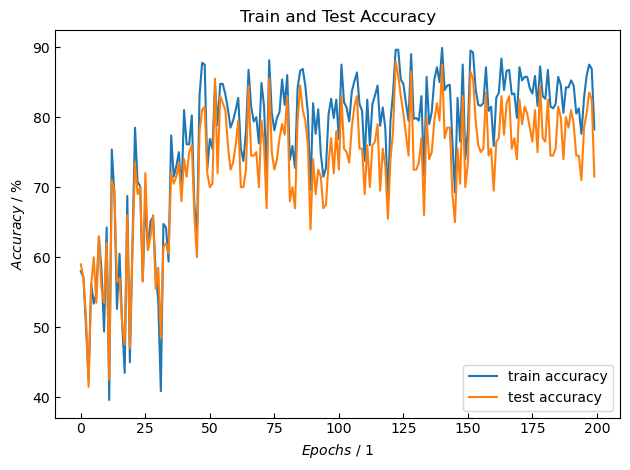

In [13]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [14]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[6.7691e+02, 2.3233e+02, 3.6931e-02, 6.1911e-01, 3.4396e-01],
        [6.7416e+02, 1.6358e+02, 5.0829e-01, 4.2732e-01, 6.4390e-02],
        [7.1670e+02, 1.3722e+02, 5.9026e-02, 8.9511e-01, 4.5863e-02],
        [6.9194e+02, 1.6590e+02, 6.2578e-01, 1.6624e-01, 2.0797e-01],
        [7.2562e+02, 1.9470e+02, 2.6268e-01, 2.9386e-01, 4.4346e-01],
        [8.4941e+02, 1.5903e+02, 9.5226e-01, 1.0870e-02, 3.6873e-02],
        [7.0024e+02, 1.9236e+02, 4.0195e-01, 2.4685e-01, 3.5120e-01],
        [6.5312e+02, 2.1408e+02, 1.4436e-01, 1.3940e-01, 7.1625e-01],
        [8.0004e+02, 1.5199e+02, 2.5276e-01, 2.8439e-01, 4.6285e-01],
        [8.3240e+02, 2.0779e+02, 8.1855e-01, 1.3594e-01, 4.5507e-02],
        [7.7151e+02, 2.0224e+02, 5.0873e-01, 3.7631e-01, 1.1496e-01],
        [7.0901e+02, 1.1099e+02, 6.0126e-01, 3.6644e-01, 3.2299e-02],
        [8.2839e+02, 2.4726e+02, 5.2262e-01, 2.1650e-01, 2.6088e-01],
        [8.0766e+02, 1.9278e+02, 9.5087e-02, 3.6725e-01, 5.3766e-01],
        [8.5010e+02,

#### Einblick in Netzwerk

In [15]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([1.0478, 1.0569, 0.9977, 1.0592, 0.9941], requires_grad=True),
 Parameter containing:
 tensor([-0.1156,  0.2030, -0.0226, -0.1520, -0.2250], requires_grad=True),
 Parameter containing:
 tensor([[-2.1037e-01,  3.5408e-01,  3.6752e-01,  2.1607e-01, -2.3161e-01],
         [ 2.4582e-01, -4.2345e-01, -1.8844e-01, -4.2576e-01,  1.5415e-01],
         [-3.6315e-01,  5.1792e-03, -5.3082e-01,  3.3231e-01, -1.3116e-01],
         [ 5.4386e-01, -2.3859e-01, -8.6638e-02, -1.8177e-01,  2.8716e-01],
         [-4.4161e-01,  4.8003e-01, -1.3462e-01,  7.1832e-02, -2.6952e-01],
         [ 4.5975e-01, -1.7271e-01, -1.0087e-01, -1.7174e-01,  2.7640e-01],
         [ 1.6203e-01, -1.8448e-01,  3.6514e-01, -1.5605e-01,  1.0222e-01],
         [ 3.6955e-01,  3.2602e-01,  3.8904e-01, -3.2614e-02, -5.9019e-01],
         [-4.2086e-02,  4.3910e-01,  4.3340e-01, -3.7530e-01, -3.7132e-01],
         [ 3.8846e-01, -2.8248e-01, -1.4403e-01, -4.6952e-01,  2.1808e-01],
         [ 3.3278e-01,  

In [16]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.1865, 0.4748, 0.8055, 0.7952, 0.5956],
        [0.1397, 0.3725, 0.6819, 0.9745, 0.2245]])
tensor([[-0.1412],
        [-0.0280]], grad_fn=<AddmmBackward0>)


In [17]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [18]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[7.6411e+02, 1.7743e+02, 1.0189e-01, 8.9479e-01, 3.3184e-03],
        [8.2292e+02, 1.5677e+02, 8.6543e-01, 1.2439e-01, 1.0177e-02],
        [7.1221e+02, 2.4247e+02, 2.5561e-01, 1.6800e-01, 5.7639e-01],
        [8.0944e+02, 1.3723e+02, 5.1277e-01, 1.1573e-01, 3.7149e-01],
        [6.8813e+02, 1.7149e+02, 5.6401e-01, 2.6631e-01, 1.6969e-01],
        [7.1641e+02, 2.3822e+02, 2.1029e-01, 3.7296e-01, 4.1675e-01],
        [8.3139e+02, 1.1061e+02, 6.4986e-02, 5.4693e-01, 3.8809e-01],
        [8.0802e+02, 1.1035e+02, 1.2620e-01, 4.5462e-01, 4.1919e-01],
        [7.7071e+02, 2.3326e+02, 5.5164e-01, 1.5453e-01, 2.9383e-01],
        [7.6388e+02, 1.0290e+02, 1.4620e-01, 3.0097e-01, 5.5284e-01],
        [7.5527e+02, 1.0415e+02, 4.3182e-02, 8.3745e-01, 1.1936e-01],
        [8.2238e+02, 1.2244e+02, 1.3905e-01, 5.8852e-01, 2.7243e-01],
        [6.8296e+02, 1.4021e+02, 1.4386e-01, 6.2938e-01, 2.2677e-01],
        [6.6917e+02, 1.3822e+02, 3.6732e-01, 4.5336e-01, 1.7932e-01],
        [6.7201e+02,